<a href="https://colab.research.google.com/github/fernanda0402/Doutorado/blob/main/Derivadas_bf%2C_teorica_e_gp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Bibliotecas:

import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sp
import scipy.interpolate as interp
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.optimize import curve_fit
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [2]:
!pip install -q condacolab
import condacolab
condacolab.install()
!mamba install pyccl

✨🍰✨ Everything looks OK!

                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (1.4.1) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['pyccl']

conda-forge/linux-64                                        Usin

In [3]:
import pyccl as ccl

In [ ]:
!pip install derivative
from derivative import dxdt

In [5]:
# dados de f

f_dados = np.array([0.56, 0.49, 0.49, 0.60, 0.70, 0.66, 0.70, 0.75, 0.73, 0.91, 0.90])
f_erro = np.array([0.07, 0.14, 0.12, 0.10, 0.18, 0.09, 0.07, 0.18, 0.07, 0.36, 0.24])
z_dados = np.array([0.013, 0.15, 0.18, 0.22, 0.35, 0.38, 0.41, 0.55, 0.60, 0.77, 1.40])

In [6]:
# primeiro modelo

cosmo = ccl.Cosmology(
    Omega_c=0.2656, Omega_b=0.0494, w0 = -1, h=0.6727, sigma8=0.8120, n_s=0.9649) 


a = np.linspace(0.33, 1, 1000)  # fator de escala
delta = ccl.growth_factor(cosmo, a)  # contraste

# definindo o redshift em função do fator de escala
z = (1/a) - 1.

x = np.log(a)
y = np.log(delta)

f = np.gradient(y, x) # função taxa de crescimento

# constantes
H0 = 70 #km/s/Mpc
Om0 = 0.30

# definindo O_m
#Om = (Om0*(a**(-3)))/(Om0*(a**(-3)) + 1 - Om0)

# definindo w0
w0 = -1
sigw0 = 0.2

# definindo gamma
gamma = 6./11.

# definindo o erro de f
f_1 = (Om0*((1 + z)**3))/( Om0*((1 + z)**3) + ( 1 - Om0 )*( (1 + z)**(3*(1+w0)) ) )
f_2 = (1 - Om0)*( (1+z)**(3*(1 + w0)) ) + Om0*((1 + z)**3)
df = ( (3*(Om0 - 1)*Om0*gamma*((1+z)**(3*(1+w0) + 3))*np.log(1+z) )/(f_2)**2)*((f_1)**(gamma-1))
sig_f = ((df)*sigw0)

In [7]:
# segundo modelo

cosmo = ccl.Cosmology(
    Omega_c=0.2656, Omega_b=0.0494, w0 = -1, h=0.6727, sigma8=0.8120, n_s=0.9649) 


a = np.linspace(0.33, 1, 1000)  # fator de escala
delta = ccl.growth_factor(cosmo, a)  # contraste

# definindo o redshift em função do fator de escala
z = (1/a) - 1.

x = np.log(a)
y = np.log(delta)

f = np.gradient(y, x) # função taxa de crescimento

# constantes
H0 = 70 #km/s/Mpc
Om0 = 0.30

# definindo O_m
#Om = (Om0*(a**(-3)))/(Om0*(a**(-3)) + 1 - Om0)
sigOm0 = 0.05

# definindo w0
w0 = -1

# definindo gamma
gamma = 6./11.

# definindo o erro de f
df1 = gamma*( ((1+z)**3)/f_2 - ( ((1+z)**3)*Om0*( ((1+z)**3) -  (1+z)**(3*(1 + w0)) ) )/( (f_2)**2) )*( (f_1)**(gamma-1) )
sig_f1 = ((df1)*sigOm0)

0.25640993263317685
-0.7952874891952177


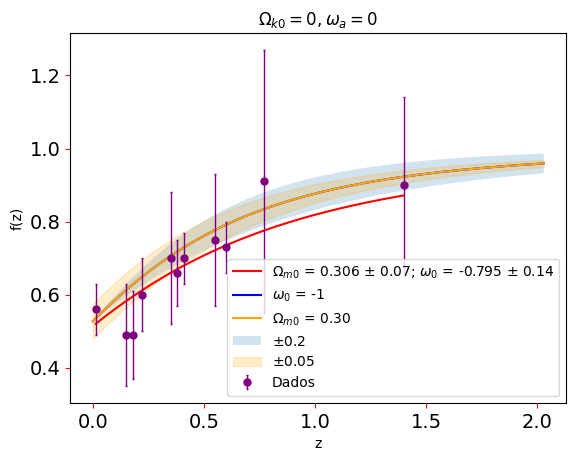

In [8]:
# primeiro best-fit

# definindo a função f para o caso de Om e w0 variando

def f1_teorico(z, Om_c, w0):

    cosmo = ccl.Cosmology(Omega_c=Om_c, h=0.6727, Omega_b=0.049411603, Omega_k=0, w0=w0, wa=0, sigma8=0.8120, n_s=0.9649)

    a = 1/(1+z)

    return ccl.background.growth_rate(cosmo, a)


# ajuste da função

popt, pcov = curve_fit(f1_teorico, z_dados, f_dados, sigma=f_erro, p0=[0.25,-1.2], bounds=([-1.5, -1.5], [1., 1.]), method='trf')
print(popt[0])
print(popt[1])

p1 = popt[0] + 0.049411603
p2 = popt[1]

erro = f_erro
e1 = erro[0]
e2 = erro[1]

# plote

#best-fit
zi = np.linspace(min(z_dados), max(z_dados), 1000)

fig, ax = plt.subplots()
plt.tick_params(labelsize=14, color='red')
plt.plot(zi, f1_teorico(zi, popt[0], popt[1]), color='red', label=r'$\Omega_{m0}$ = '+str(np.round(p1, 3))+' $\pm$ '+str(np.round(e1, 4))+'; '+'$\omega_0$ = '+str(np.round(p2, 3))+' $\pm$ '+str(np.round(e2, 4)))

#curvas e dados
ax.plot(z, f, label='$\omega_0$ = -1', color='blue')
ax.plot(z, f, label='$\Omega_{m0}$ = 0.30', color='orange')
plt.errorbar(z_dados, f_dados, yerr = f_erro, color = 'purple', label='Dados', fmt='o', markersize=5, elinewidth=1, capsize=1)

# área sombreada
ax.fill_between(z, f - sig_f, f + sig_f, alpha=0.2, label='$\pm$0.2')
ax.fill_between(z, f - sig_f1, f + sig_f1, alpha=0.2, color='orange', label='$\pm$0.05')

# legenda, título e eixos
plt.legend(loc='best')
plt.xlabel('z')
plt.ylabel('f(z)')
plt.title('$\Omega_{k0} = 0, \omega_a = 0$')
plt.show()

A partir de agora vamos comparar as derivadas.

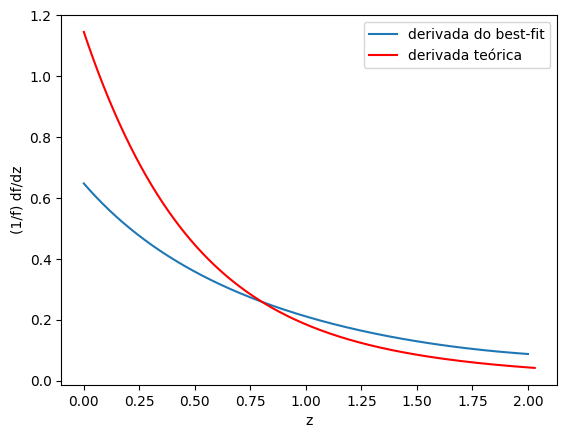

In [9]:
# DERIVADA DO BEST-FIT
zi = np.linspace(min(z_dados), max(z_dados), 1000)

def f11_teorico(z, Om_c, w0):

    cosmo = ccl.Cosmology(Omega_c=Om_c, h=0.6727, Omega_b=0.049411603, Omega_k=0, w0=w0, wa=0, sigma8=0.8120, n_s=0.9649)

    ai = 1/(1+zi)

    return ccl.background.growth_rate(cosmo, ai)

# derivada usando cubic spline

x1 = np.linspace(0, 2.0, 1000)
y1 = f11_teorico(zi, *popt)

# 4. Spline derivative with smoothing set to 0.01
result4 = dxdt(y1, x1, kind="spline", s=1e-2)
derivada_bf = result4/f11_teorico(zi, *popt)



# DERIVADA TEÓRICA
gamma = 6/11
Om0 = 0.30
O_L0 = 1 - Om0

derivada_teo = ( (3 * gamma * O_L0)/( (1+z) * (Om0 * ((1+z)**3) + O_L0) ) )



# PLOTE
plt.plot(x1, derivada_bf, label='derivada do best-fit')
plt.plot(z, derivada_teo, label='derivada teórica', color='red')

# legenda, título e eixos
plt.ylabel('(1/f) df/dz')
plt.xlabel('z')
plt.legend()
plt.show()

Abaixo, faremos a derivada dos dados preditos de $f$ reconstruídos pelo Felipe.

In [10]:
# dados preditos de f

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
dados_f = np.loadtxt('/content/drive/MyDrive/Doutorado/reconstruction_data.txt')
dados_f

# nomeando dados/colunas

zp = dados_f[:, 0] # o redshift é a primeira coluna
fp = dados_f[:, 1] # f(z) é a segunda coluna
fp_maissigma = dados_f[:, 2] # f + 2 sigma é a terceira coluna
fp_menossigma = dados_f[:, 3] # f - 2 sigma é a quarta coluna

#print(z)

fp_sigma = (fp_maissigma + fp_menossigma)/2

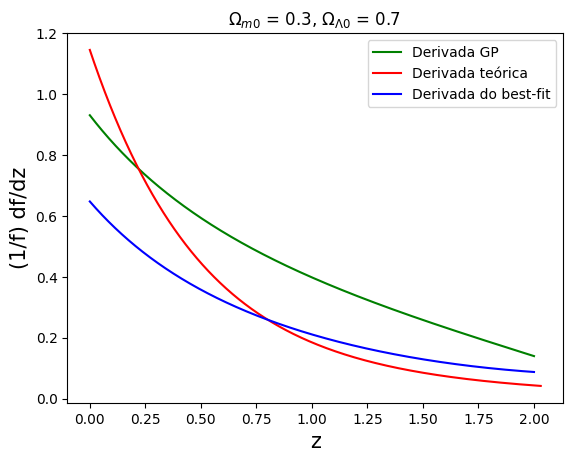

In [18]:
# DERIVADA TEÓRICA
gamma = 6/11
Om0 = 0.30
O_L0 = 1 - Om0

derivada_teo = ( (3 * gamma * O_L0)/( (1+z) * (Om0 * ((1+z)**3) + O_L0) ) )



# DERIVADA DO GP USANDO SPLINE

xgp = np.linspace(0,2.0,1000)
ygp = fp

# 4. Spline derivative with smoothing set to 0.01
result_gp = dxdt(ygp, xgp, kind="spline", s=1e-2)
derivada_gp = result_gp/fp



# PLOTE
plt.plot(xgp, derivada_gp, label='Derivada GP', color='green')
plt.plot(z, derivada_teo, label='Derivada teórica', color='red')
plt.plot(x1, derivada_bf, label='Derivada do best-fit', color='blue')

# legenda, título e eixos
plt.ylabel('(1/f) df/dz', fontsize=15)
plt.xlabel('z', fontsize=15)
plt.title('$\Omega_{m0}$ = 0.3, $\Omega_{\Lambda 0}$ = 0.7 ')
plt.legend()
plt.show()

Vmaos plotar a derivada de $f$ do best-fit com o seu erro associado.

<ipython-input-32-10e28248f686>:46: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(zi, df_dbf1, 'b-', label='Prediction', linestyle="--")


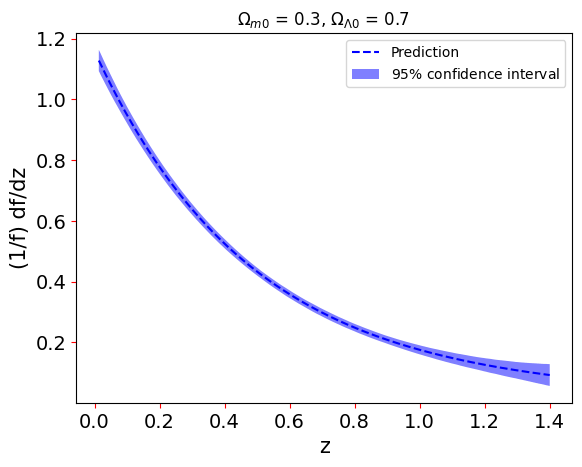

In [32]:
# DERIVADA DO BEST-FIT
zi = np.linspace(min(z_dados), max(z_dados), 1000)

def f11_teorico(z, Om_c, w0):

    cosmo = ccl.Cosmology(Omega_c=Om_c, h=0.6727, Omega_b=0.049411603, Omega_k=0, w0=w0, wa=0, sigma8=0.8120, n_s=0.9649)

    ai = 1/(1+zi)

    return ccl.background.growth_rate(cosmo, ai)

f_dbf = ccl.growth_rate(cosmo, ai)

ef_dbf = np.linspace(0.05, 0.05, 1000)

#df_dbf = np.gradient(f_dbf, zi)

df_dbf1 = np.gradient(f_dbf, zi) / f_dbf



N = 1000

dfi = []
for i in range(N):
    
    fi = np.random.normal(f_dbf, ef_dbf)
    
    dfi.append(dxdt(fi, zi, kind="savitzky_golay", left=.5, right=.5, order=1))

dfi = np.array(dfi)

sig_df = []
for i in range(len(zi)):

    sig_df.append(np.std(dfi[:, i]))

sig_df = np.array(sig_df)



# PLOTE

plt.figure()
plt.tick_params(labelsize=14,color='red')
plt.plot(zi, df_dbf1, 'b-', label='Prediction', linestyle="--")
plt.fill(np.concatenate([zi, zi[::-1]]),
         np.concatenate([df_dbf1 - 1.9600 * sig_df,
                        (df_dbf1 + 1.9600 * sig_df)[::-1]]),
         alpha=.5, fc='b', ec='None', label=r'$95\%$ confidence interval')

# legenda, título e labels
plt.ylabel('(1/f) df/dz', fontsize=15)
plt.xlabel('z', fontsize=15)
plt.title('$\Omega_{m0}$ = 0.3, $\Omega_{\Lambda 0}$ = 0.7 ')
plt.legend(loc='best')
plt.show()

Vamos buscar um valor de $\gamma$ que faça com que a curva da derivada teórica fique mais próxima da curva do best-fit e/ou da curva do GP. Além disso, vamos incluir os erros do best-fit no plot.

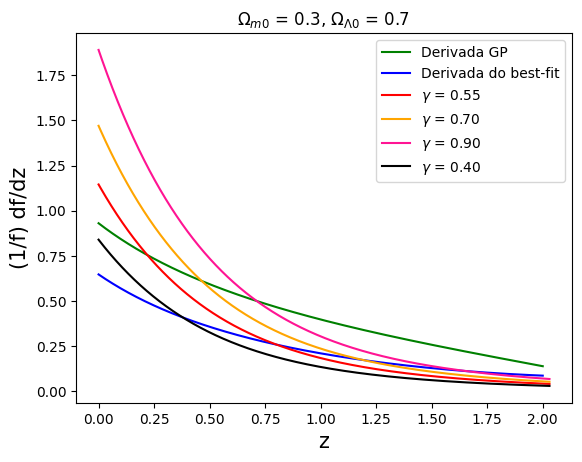

In [17]:
# novo valor para gamma

om = 0.3
ol = 1 - om
gamma_new = 6/11

#f_new = om ** gamma_new

derivada_teo_new = ( (3 * gamma_new * ol)/( (1+z) * (om * ((1+z)**3) + ol) ) )




# outro gamma 1 

om = 0.3
ol = 1 - om
gamma_new1 = 0.70

#f_new1 = om ** gamma_new1


derivada_teo_new1 = ( (3 * gamma_new1 * ol)/( (1+z) * (om * ((1+z)**3) + ol) ) )



# outro gamma 2

om = 0.3
ol = 1 - om
gamma_new2 = 0.90

#f_new2 = om ** gamma_new2

derivada_teo_new2 = ( (3 * gamma_new2 * ol)/( (1+z) * (om * ((1+z)**3) + ol) ) ) 



# outro gamma 3

om = 0.3
ol = 1 - om
gamma_new3 = 0.4

#f_new3 = om ** gamma_new3

derivada_teo_new3 = ( (3 * gamma_new3 * ol)/( (1+z) * (om * ((1+z)**3) + ol) ) ) 



# DERIVADA DO BEST-FIT
zi = np.linspace(min(z_dados), max(z_dados), 1000)

def f11_teorico(z, Om_c, w0):

    cosmo = ccl.Cosmology(Omega_c=Om_c, h=0.6727, Omega_b=0.049411603, Omega_k=0, w0=w0, wa=0, sigma8=0.8120, n_s=0.9649)

    ai = 1/(1+zi)

    return ccl.background.growth_rate(cosmo, ai)

# derivada usando cubic spline

x1 = np.linspace(0, 2.0, 1000)
y1 = f11_teorico(zi, *popt)

# 4. Spline derivative with smoothing set to 0.01
result4 = dxdt(y1, x1, kind="spline", s=1e-2)
derivada_bf = result4/f11_teorico(zi, *popt)




# PLOTE
fig, ax = plt.subplots()

plt.plot(xgp, derivada_gp, label='Derivada GP', color='green')
plt.plot(x1, derivada_bf, label='Derivada do best-fit', color='blue')
plt.plot(z, derivada_teo_new, label='$\gamma$ = 0.55', color='red')
plt.plot(z, derivada_teo_new1, label='$\gamma$ = 0.70', color='orange')
plt.plot(z, derivada_teo_new2, label='$\gamma$ = 0.90', color='deeppink')
plt.plot(z, derivada_teo_new3, label='$\gamma$ = 0.40', color='black')

# área sombrada (erros do best-fit) ERRADO
#ax.fill_between(x1, derivada_bf - np.round(e1, 4), derivada_bf + np.round(e1, 4), alpha=0.2, color='blue', label='Erro do best-fit') # np.round(e1,4) é o erro de Om0 no primeiro best-fit
#ax.fill_between(x1, derivada_bf - np.round(e2, 4), derivada_bf + np.round(e2, 4), alpha=0.2, color='midnightblue') # np.round(e2,4) é o erro de w0 no primeiro best-fit

# legenda, título e eixos
plt.ylabel('(1/f) df/dz', fontsize=15)
plt.xlabel('z', fontsize=15)
plt.title('$\Omega_{m0}$ = 0.3, $\Omega_{\Lambda 0}$ = 0.7 ')
plt.legend()
plt.show()

Agora vamos comparar as derivadas teórica, do best-fit e do Gaussian Process oriundo do GaPP junto com seus erros.

In [ ]:
!pip install git+https://github.com/JCGoran/GaPP@feature/python3#GaPP
from gapp import gp
from numpy import loadtxt, savetxt
from gapp import dgp # dgp calcula a primeira, segunda e terceira derivada

<ipython-input-35-9b7d390f3e57>:74: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(zi, df_dbf1, 'b-', label='Prediction', linestyle="--")


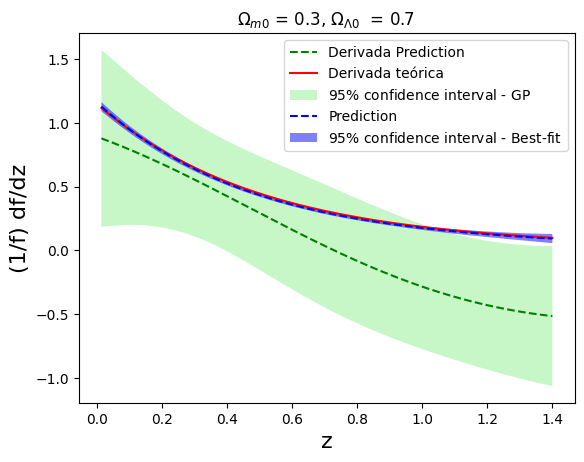

In [35]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

# DERIVADA DO GAUSSIAN PROCESS GAPP
# baixando e nomeando dados
fz = np.genfromtxt('/content/drive/MyDrive/Doutorado/fz_recon.dat', delimiter='\t')

z_gapp = fz[:, 0]
f_gapp = fz[:, 1]

ef = fz[:, 2]

dfz = np.genfromtxt('/content/drive/MyDrive/Doutorado/dfz_recon.dat', delimiter='\t')

df = dfz[:, 1]

edf = dfz[:, 2]

df_f = df / f_gapp

sigma = np.sqrt(((df_f) ** 2) * (((ef / f_gapp) ** 2) + ((edf / df) ** 2)))



# DERIVADA DO MODELO LCDM

cosmo = ccl.Cosmology(
    Omega_c=0.2656, Omega_b=0.0494, h=0.6727, sigma8=0.8120, n_s=0.9649,
    matter_power_spectrum='linear')

z2 = np.linspace(min(z_gapp), max(z_gapp), 1000)

ai = 1. / (1. + z2)

gamma = 6/11
Om0 = 0.30
O_L0 = 1 - Om0

derivada_teo = ( (3 * gamma * O_L0)/( (1+z2) * (Om0 * ((1+z2)**3) + O_L0) ) )



# DERIVADA DO BEST-FIT
zi = np.linspace(min(z_dados), max(z_dados), 1000)

def f11_teorico(z, Om_c, w0):

    cosmo = ccl.Cosmology(Omega_c=Om_c, h=0.6727, Omega_b=0.049411603, Omega_k=0, w0=w0, wa=0, sigma8=0.8120, n_s=0.9649)

    ai = 1/(1+zi)

    return ccl.background.growth_rate(cosmo, ai)

# derivada usando cubic spline

x1 = np.linspace(0, 1.4, 1000)
y1 = f11_teorico(zi, *popt)

# 4. Spline derivative with smoothing set to 0.01
result4 = dxdt(y1, x1, kind="spline", s=1e-2)
derivada_bf = result4/f11_teorico(zi, *popt)



# plote
fig, ax = plt.subplots()

plt.plot(z_gapp, df_f, color='green', label='Derivada Prediction', linestyle="--")
plt.plot(z2, derivada_teo, label='Derivada teórica', color='red')
plt.fill(np.concatenate([z_gapp, z_gapp[::-1]]),
         np.concatenate([df_f - 1.9600 * sigma,
                        (df_f + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label='$95\%$ confidence interval - GP')
plt.plot(zi, df_dbf1, 'b-', label='Prediction', linestyle="--")
plt.fill(np.concatenate([zi, zi[::-1]]),
         np.concatenate([df_dbf1 - 1.9600 * sig_df,
                        (df_dbf1 + 1.9600 * sig_df)[::-1]]),
         alpha=.5, fc='blue', ec='None', label=r'$95\%$ confidence interval - Best-fit')

# área sombrada (erros do best-fit)
#ax.fill_between(x1, derivada_bf - np.round(e1, 4), derivada_bf + np.round(e1, 4), alpha=0.2, color='blue', label='Erro do best-fit') # np.round(e1,4) é o erro de Om0 no primeiro best-fit
#ax.fill_between(x1, derivada_bf - np.round(e2, 4), derivada_bf + np.round(e2, 4), alpha=0.2, color='midnightblue') # np.round(e2,4) é o erro de w0 no primeiro best-fit

# legenda, label e título
plt.title('$\Omega_{m0}$ = 0.3, $\Omega_{\Lambda 0}$  = 0.7 ')
plt.xlabel('z', fontsize=16)
plt.ylabel('(1/f) df/dz', fontsize=16)
plt.legend(loc='best')
plt.show()